In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.2.3
0.6.0
4.3.3


In [2]:
import pandas as pd

# 데이터를 읽어봅시다.
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘',
             '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
index_to_word = {index: word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    # [1:]를 통해 <BOS>를 제외
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


데이터셋 내 문장 길이 분포    
적절한 최대 문장 길이 지정    
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',  # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',  # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

2024-11-25 08:09:42.098082: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 08:09:42.113685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 08:09:42.113700: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 08:09:42.113710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 08:09:42.116841: I tensorflow/core/platform/cpu_feature_g

(146182, 41)


In [10]:
# validation set 29236건 분리
x_val = X_train[:29236]
y_val = y_train[:29236]

# validation set을 제외한 나머지 
partial_x_train = X_train[29236:]
partial_y_train = y_train[29236:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116946, 41)
(116946,)
(29236, 41)
(29236,)


In [11]:
vocab_size = len(index_to_word)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# maxlen : 문장 최대길이

모델 1

In [12]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, input_shape=(None,)))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.LSTM(8))
model1.add(tf.keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 3488      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1003569 (3.83 MB)
Trainable params: 1003569 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-25 08:09:42.878204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 08:09:42.880899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 08:09:42.880979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

모델2

In [13]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          11216     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                

모델3

In [14]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
# 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 global_max_pooling1d_1 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 8)                 808       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1000817 (3.82 MB)
Trainable params: 1000817 (3.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20


2024-11-25 08:09:44.054695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-11-25 08:09:44.299216: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f60edae6550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-25 08:09:44.299230: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-25 08:09:44.301575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-25 08:09:44.345180: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 [==============================] - 11s 42ms/step - loss: 0.5232 - accuracy: 0.7321 - val_loss: 0.3702 - val_accuracy: 0.8431
Epoch 2/20
229/229 [==============================] - 3s 14ms/step - loss: 0.3442 - accuracy: 0.8557 - val_loss: 0.3480 - val_accuracy: 0.8494
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3090 - accuracy: 0.8698 - val_loss: 0.3590 - val_accuracy: 0.8431
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2893 - accuracy: 0.8780 - val_loss: 0.3566 - val_accuracy: 0.8490
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2707 - accuracy: 0.8840 - val_loss: 0.3575 - val_accuracy: 0.8542
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2519 - accuracy: 0.8924 - val_loss: 0.3871 - val_accuracy: 0.8528
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2355 - accuracy: 0.9000 - val_loss: 0.3714 - val_accuracy: 0.8544
Epoch 8/20
229

In [ ]:
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history2 = model2.fit(partial_x_train,
                      partial_y_train,
                      epochs=epochs,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/20
229/229 [==============================] - 6s 24ms/step - loss: 0.4738 - accuracy: 0.7559 - val_loss: 0.3475 - val_accuracy: 0.8494
Epoch 2/20
229/229 [==============================] - 2s 10ms/step - loss: 0.3157 - accuracy: 0.8665 - val_loss: 0.3311 - val_accuracy: 0.8556
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2662 - accuracy: 0.8921 - val_loss: 0.3375 - val_accuracy: 0.8549
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2110 - accuracy: 0.9199 - val_loss: 0.3591 - val_accuracy: 0.8516
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.1530 - accuracy: 0.9457 - val_loss: 0.4099 - val_accuracy: 0.8454
Epoch 6/20
229/229 [==============================] - 1s 3ms/step - loss: 0.1052 - accuracy: 0.9645 - val_loss: 0.4733 - val_accuracy: 0.8452
Epoch 7/20
229/229 [==============================] - 1s 3ms/step - loss: 0.0720 - accuracy: 0.9767 - val_loss: 0.5438 - val_accuracy: 0.8369
Epoc

In [ ]:
model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history3 = model3.fit(partial_x_train,
                      partial_y_train,
                      epochs=epochs,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/20
229/229 [==============================] - 6s 24ms/step - loss: 0.4963 - accuracy: 0.7949 - val_loss: 0.3591 - val_accuracy: 0.8414
Epoch 2/20
229/229 [==============================] - 2s 10ms/step - loss: 0.3264 - accuracy: 0.8616 - val_loss: 0.3375 - val_accuracy: 0.8518
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2811 - accuracy: 0.8842 - val_loss: 0.3387 - val_accuracy: 0.8527
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2462 - accuracy: 0.9022 - val_loss: 0.3474 - val_accuracy: 0.8530
Epoch 5/20
229/229 [==============================] - 1s 3ms/step - loss: 0.2145 - accuracy: 0.9171 - val_loss: 0.3611 - val_accuracy: 0.8527
Epoch 6/20
229/229 [==============================] - 1s 3ms/step - loss: 0.1831 - accuracy: 0.9325 - val_loss: 0.3824 - val_accuracy: 0.8497
Epoch 7/20
229/229 [==============================] - 1s 3ms/step - loss: 0.1527 - accuracy: 0.9472 - val_loss: 0.4084 - val_accuracy: 0.8490
Epoc

In [18]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)
results3 = model3.evaluate(X_test,  y_test, verbose=2)


print(results1)
print(results2)
print(results3)

1537/1537 - 1s - loss: 0.5723 - accuracy: 0.8383 - 1s/epoch - 741us/step
1537/1537 - 1s - loss: 1.1883 - accuracy: 0.8256 - 735ms/epoch - 478us/step
1537/1537 - 1s - loss: 0.8707 - accuracy: 0.8272 - 614ms/epoch - 399us/step
[0.5722880959510803, 0.8382529616355896]
[1.188294529914856, 0.8255589008331299]
[0.8706859946250916, 0.8272067308425903]


Visualization

In [19]:
print(history1.history.keys())  # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


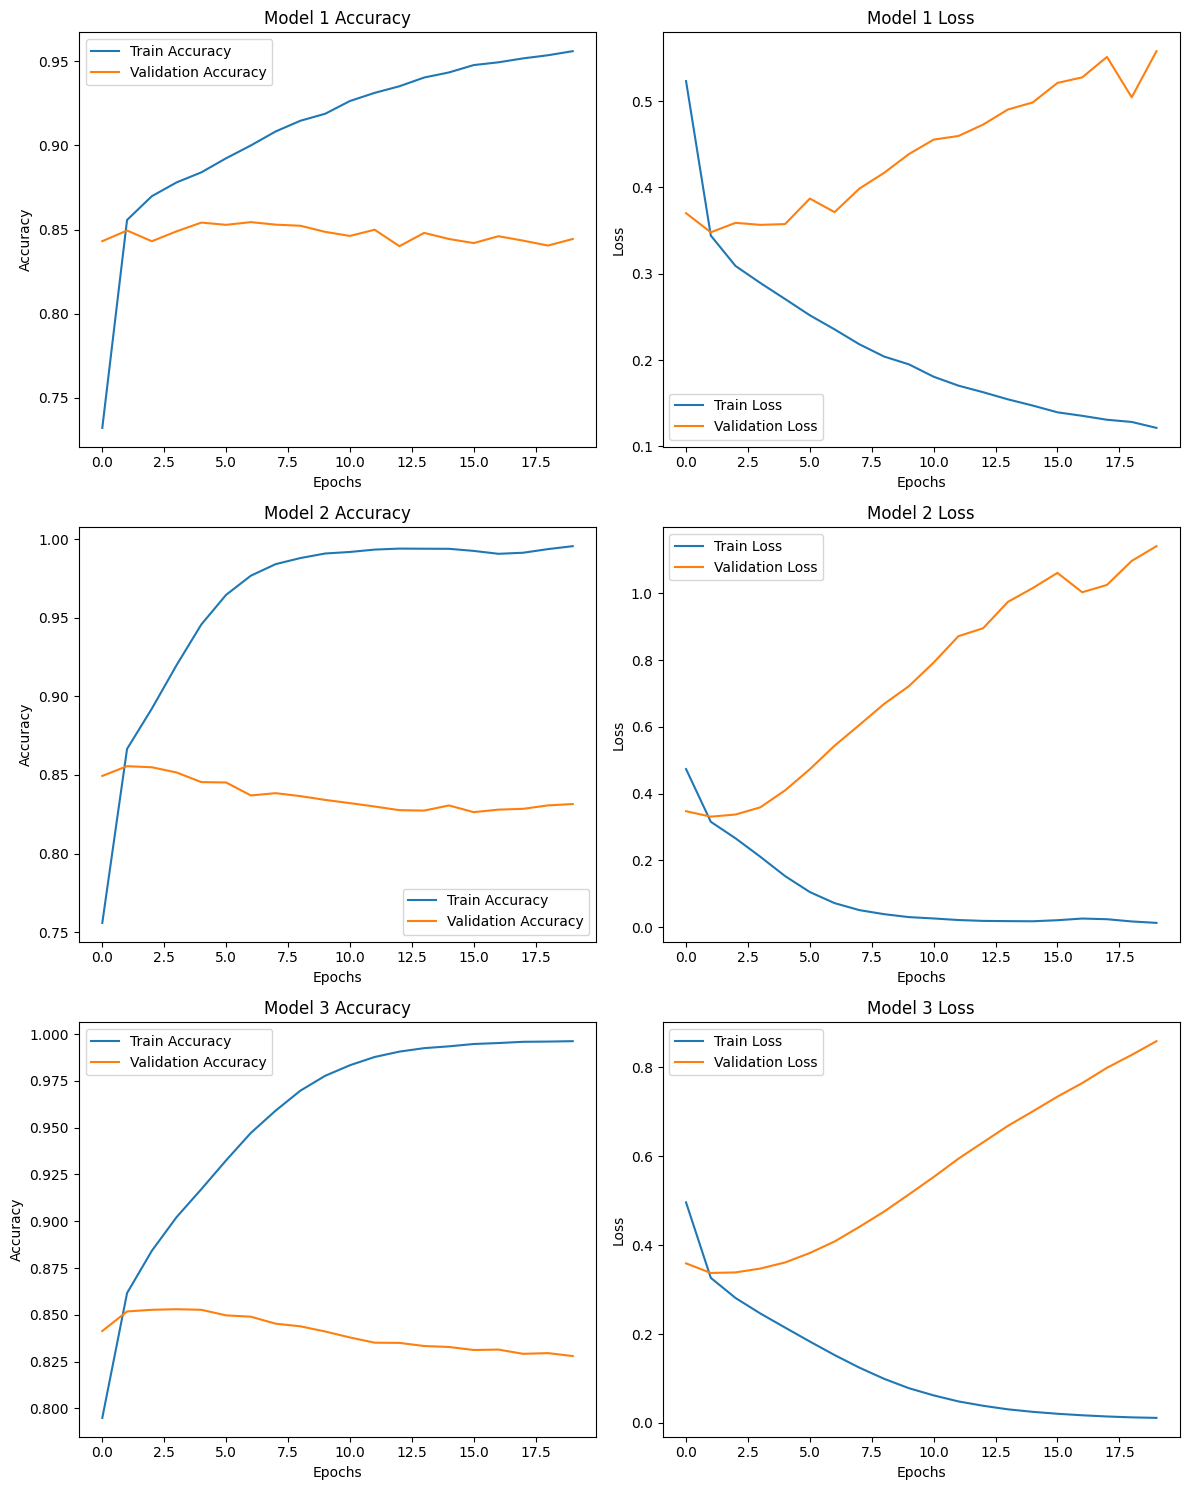

In [ ]:
import matplotlib.pyplot as plt

acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs = range(1, len(acc1) + 1)

# Figure 생성 (3행 2열)
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot 1: Model 1 Accuracy
axes[0, 0].plot(epochs, acc1, label='Train Accuracy')
axes[0, 0].plot(epochs, val_acc1, label='Validation Accuracy')
axes[0, 0].set_title('Model 1 Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot 2: Model 1 Loss
axes[0, 1].plot(epochs, loss1, label='Train Loss')
axes[0, 1].plot(epochs, val_loss1, label='Validation Loss')
axes[0, 1].set_title('Model 1 Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plot 3: Model 2 Accuracy
axes[1, 0].plot(epochs, acc2, label='Train Accuracy')
axes[1, 0].plot(epochs, val_acc2, label='Validation Accuracy')
axes[1, 0].set_title('Model 2 Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot 4: Model 2 Loss
axes[1, 1].plot(epochs, loss2, label='Train Loss')
axes[1, 1].plot(epochs, val_loss2, label='Validation Loss')
axes[1, 1].set_title('Model 2 Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Plot 5: Model 3 Accuracy
axes[2, 0].plot(epochs, acc3, label='Train Accuracy')
axes[2, 0].plot(epochs, val_acc3, label='Validation Accuracy')
axes[2, 0].set_title('Model 3 Accuracy')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot 6: Model 3 Loss
axes[2, 1].plot(epochs, loss3, label='Train Loss')
axes[2, 1].plot(epochs, val_loss3, label='Validation Loss')
axes[2, 1].set_title('Model 3 Loss')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

# Layout 조정 및 출력
plt.tight_layout()
plt.show()

Embedding layer Analysis

In [21]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [22]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './data/word2vec.txt'
f = open(word2vec_file_path, 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model1.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(
        map(str, list(vectors[i, :])))))
f.close()

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(
    word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.05327526,  0.09125027, -0.13965529, -0.10612181, -0.02989827,
       -0.11937886,  0.19505538,  0.1440964 , -0.01560073, -0.0615891 ,
       -0.03375069, -0.05535129, -0.2716193 , -0.01142643, -0.02469977,
       -0.15405776, -0.11116617, -0.04282552, -0.01829872,  0.03602126,
        0.10576504,  0.3155382 ,  0.05233791,  0.03695952, -0.12222105,
        0.03363943, -0.09208395,  0.02918381, -0.0761952 , -0.09244359,
        0.1862199 ,  0.01369086,  0.04854216,  0.12244764, -0.03770209,
        0.11959689, -0.00394493, -0.04558255, -0.12859108,  0.09741839,
        0.10167226,  0.05096271,  0.01799692, -0.12483975,  0.06413323,
       -0.07143365, -0.01164998, -0.03690573,  0.0677149 ,  0.08416037,
       -0.05073221,  0.0903324 ,  0.09106586,  0.14923193,  0.00945398,
       -0.22451636, -0.10318847, -0.05957523,  0.02846813, -0.02424856,
       -0.02540501, -0.04245095,  0.10600591, -0.0990041 ,  0.01161507,
       -0.00702819,  0.08665709, -0.02555006,  0.1003711 , -0.09

In [24]:
word_vectors.similar_by_word("사랑")

[('순수', 0.865276575088501),
 ('죄책감', 0.831657350063324),
 ('출', 0.8301573395729065),
 ('최고', 0.8283496499061584),
 ('뛰어넘', 0.8179196119308472),
 ('짝짝', 0.8168175220489502),
 ('강렬', 0.8153465986251831),
 ('지리', 0.8152489066123962),
 ('민감', 0.8134829998016357),
 ('기다려', 0.8104410171508789)]

학습노드에서 배웠다 싶이 유사한 다른 단어를 잘 찾았다고 느껴지지 않는다.   
따라서 한국어 Word2Vec 임베딩을 활용해본다.

In [25]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = './data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

vector = word_vectors.wv['끝']

In [26]:
vector.shape

(100,)

In [27]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167418003082275),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034595608711243),
 ('마음', 0.6972615122795105)]

In [28]:
word_vectors.wv.similar_by_word("끝")

[('마지막', 0.6325399875640869),
 ('결판', 0.5526014566421509),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.541890025138855),
 ('막바지', 0.5412754416465759),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813125610352),
 ('이어진', 0.5038794279098511)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있었습니다.    
이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.

In [29]:
vocab_size = 10000
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [48]:
from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
def model_build():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                    input_length=maxlen, 
                                    trainable=True))   # trainable을 True로 주면 Fine-tuning
    model.add(tf.keras.layers.LSTM(16,dropout=0.2,recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

model = model_build()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 lstm_5 (LSTM)               (None, 16)                7488      
                                                                 
 dense_20 (Dense)            (None, 8)                 136       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1007633 (3.84 MB)
Trainable params: 1007633 (3.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 15s 61ms/step - loss: 0.6890 - accuracy: 0.5220 - val_loss: 0.6224 - val_accuracy: 0.6696
Epoch 2/20
229/229 [==============================] - 11s 46ms/step - loss: 0.5493 - accuracy: 0.7278 - val_loss: 0.4673 - val_accuracy: 0.7864
Epoch 3/20
229/229 [==============================] - 10s 42ms/step - loss: 0.4560 - accuracy: 0.7920 - val_loss: 0.4103 - val_accuracy: 0.8176
Epoch 4/20
229/229 [==============================] - 10s 42ms/step - loss: 0.4153 - accuracy: 0.8131 - val_loss: 0.3823 - val_accuracy: 0.8327
Epoch 5/20
229/229 [==============================] - 9s 40ms/step - loss: 0.3888 - accuracy: 0.8281 - val_loss: 0.3690 - val_accuracy: 0.8388
Epoch 6/20
229/229 [==============================] - 9s 41ms/step - loss: 0.3707 - accuracy: 0.8366 - val_loss: 0.3590 - val_accuracy: 0.8423
Epoch 7/20
229/229 [==============================] - 9s 40ms/step - loss: 0.3581 - accuracy: 0.8423 - val_loss: 0.3532 - val_accuracy: 0.

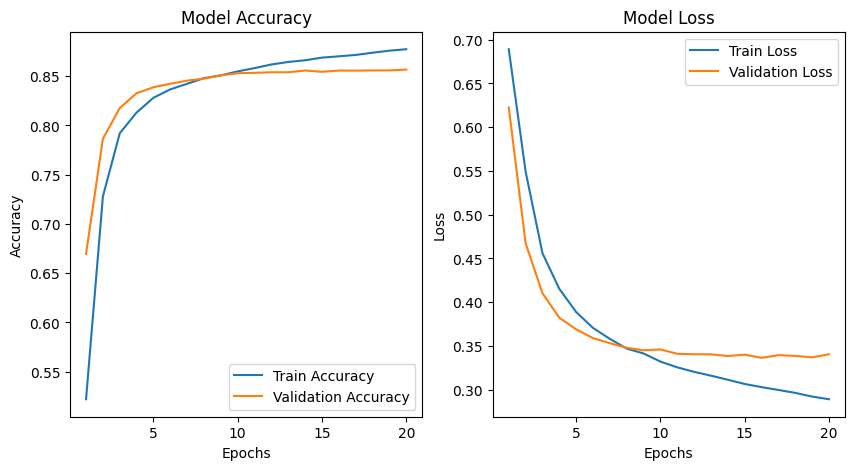

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Model Accuracy
axes[0].plot(epochs, acc, label='Train Accuracy')
axes[0].plot(epochs, val_acc, label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot 2: Model Loss
axes[1].plot(epochs, loss, label='Train Loss')
axes[1].plot(epochs, val_loss, label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [52]:
model = model_build()

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = int(10 * 1.2)  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    verbose=1)

Epoch 1/12
286/286 [==============================] - 18s 57ms/step - loss: 0.6892 - accuracy: 0.5107
Epoch 2/12
286/286 [==============================] - 12s 43ms/step - loss: 0.5243 - accuracy: 0.7401
Epoch 3/12
286/286 [==============================] - 12s 41ms/step - loss: 0.4262 - accuracy: 0.8057
Epoch 4/12
286/286 [==============================] - 11s 40ms/step - loss: 0.3872 - accuracy: 0.8265
Epoch 5/12
286/286 [==============================] - 12s 41ms/step - loss: 0.3670 - accuracy: 0.8368
Epoch 6/12
286/286 [==============================] - 11s 39ms/step - loss: 0.3527 - accuracy: 0.8457
Epoch 7/12
286/286 [==============================] - 11s 38ms/step - loss: 0.3419 - accuracy: 0.8506
Epoch 8/12
286/286 [==============================] - 11s 39ms/step - loss: 0.3332 - accuracy: 0.8557
Epoch 9/12
286/286 [==============================] - 11s 39ms/step - loss: 0.3273 - accuracy: 0.8584
Epoch 10/12
286/286 [==============================] - 11s 39ms/step - loss: 0.320

In [53]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3409 - accuracy: 0.8528 - 7s/epoch - 5ms/step
[0.34091055393218994, 0.8528185486793518]
